In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
from collections import defaultdict

# 1. Эксперимент с игрой

В мобильном приложении онлайн-магазина есть игра.
</br>По нашим наблюдения, чем больше играют, тем больше покупают и тратят бонусные баллы.
</br>Улучшили игровой баланс, чтобы увеличить среднюю длину сессии в игре.
</br>Провели эксперимент.

#### Параметры эксперимента:

- метрика средняя длина сессии;
- проверяем гипотезу о равенстве средних;
- период эксперимента — с 2024-05-11 по 2024-05-17 включительно;
- уровень значимости — 0.05.

#### Данные

Данные содержатся в файле `game_sessions.csv`. В нём есть 4 стобца:
- date - дата игровой сессии
- value - время обработки запроса в миллисекундах
- group - какой версией бэкенда обрабатывался запрос:
    - 0 - старой (контрольная группа)
    - 1 - новой (экспериментальная группа)


В данном эксперименте влияние оказывается по пользователям, а сравниваются сессии.
</br>Проверим, что вероятности ошибок контролируются.

1. Загрузим датасет. Отфильтруем датасет, оставив данные до эксперимента, для оценки вероятностей ошибок.
2. Проведём 10000 синтетических АА тестов c размером групп 500, построим распределение p-value.

In [2]:
df = pd.read_csv('06-game_sessions.csv', parse_dates=['date'])
df_prepilot = df[df['date'] < datetime(2024, 5, 11)].copy()

In [3]:
df.head()

,date,user_id,group,value
0,2024-05-04,0,1,1320
1,2024-05-04,8,1,958
2,2024-05-04,13,1,375
3,2024-05-04,16,0,774
4,2024-05-04,24,1,292


In [4]:
def plot_pvalue_distribution_power(dict_pvalues, alpha=0.05):
    """Рисует графики распределения pvalue."""
    X = np.linspace(0, 1, 1000)
    for key, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues <= x) for x in X]
        prob_p = np.mean(np.array(pvalues) < alpha)
        plt.plot(X, Y, label=f'{key}, prob_p={prob_p:0.2f}')
    plt.plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

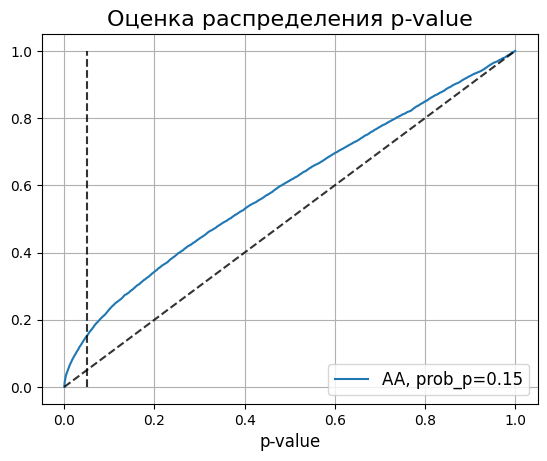

In [5]:
all_user_ids = df_prepilot['user_id'].unique()

pvalues = []
for _ in tqdm(range(10000)):
    a_user_ids, b_user_ids = np.random.choice(all_user_ids, (2, 500), False)
    a = df_prepilot[df_prepilot['user_id'].isin(a_user_ids)]['value'].values
    b = df_prepilot[df_prepilot['user_id'].isin(b_user_ids)]['value'].values
    pvalue = stats.ttest_ind(a, b).pvalue
    pvalues.append(pvalue)

plot_pvalue_distribution_power({'AA': pvalues})

# 2. Метрики отношения (ratio metrics)

Формально метрики отношения можно представить формулой, как отношения двух сумм:
$$\mathfrak{R} = \frac{X_1 + \ldots + X_N}{Y_1 + \ldots + Y_N}$$
где $N$ — размер группы, $X_i$ и $Y_i$ — метрики i-го объекта.

Например, для средней длины сессии $X_i$ — суммарная продолжительность сессий i-го пользователя, $Y_i$ — количество сессий i-го пользователя.

Значения от одного объекта обычно являются зависимыми. Если пользователь приложения всегда проводит в нём много времени за раз, то следующая его сессия, скорее всего, тоже будет долгой.

Значения от разных объектов обычно являются независимыми, или их зависимость настолько мала, что ей можно пренебречь. Информация о длинах сессий одного пользователя не помогает нам понять, какие длины сессий у другого пользователя.

# 3. Бутстреп


1. Генерируем случайные выборки пользователей из пилотной и контрольной групп $(A_{bs}, B_{bs})$;
2. Для каждой пары сэмплов считаем разность их ratio метрик
    $$\Delta = \mathfrak{R}_{B_{bs}} - \mathfrak{R}_{A_{bs}} = \frac{\sum\limits_{u\in B_{bs}} X(u)}{\sum\limits_{u\in B_{bs}} Y(u)} - \frac{\sum\limits_{u\in A_{bs}} X(u)}{\sum\limits_{u\in A_{bs}} Y(u)}$$
3. Повторяем первые два шага, чтобы набрать достаточно данных;
4. По полученному множеству дельт оцениваем значимость отличия от нуля разности метрик.


In [6]:
def check_bootstrap_ratio(a, b, n=1000):
    """Проверка гипотезы о равенстве средних метрики отношения с помощью бутстрепа.

    a: List[List], список списков длин сессий пользователей контрольной группы
    b: List[List], список списков длин сессий пользователей пилотной группы
    n: int, кол-во итераций бутстрепа

    return: (pvalue, pe) - pvalue и точечная оценка разности средних.
    """
    len_a = len(a)
    len_b = len(b)
    xy_a = np.array([[sum(row), len(row)] for row in a])
    xy_b = np.array([[sum(row), len(row)] for row in b])
    indexes_a = np.random.choice(np.arange(len_a), size=(n, len_a), replace=True)
    indexes_b = np.random.choice(np.arange(len_b), size=(n, len_b), replace=True)
    bootstrap_stats = []
    for idx_a, idx_b in zip(indexes_a, indexes_b):
        bootstrap_xy_a = xy_a[idx_a]
        bootstrap_xy_b = xy_b[idx_b]
        bootstrap_stat = (
            bootstrap_xy_b[:, 0].sum() / bootstrap_xy_b[:, 1].sum()
            - bootstrap_xy_a[:, 0].sum() / bootstrap_xy_a[:, 1].sum()
        )
        bootstrap_stats.append(bootstrap_stat)
    pe = xy_b[:, 0].sum() / xy_b[:, 1].sum() - xy_a[:, 0].sum() / xy_a[:, 1].sum()
    std = np.std(bootstrap_stats)
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(pe / std)))
    return pvalue, pe

Проверим корректность работы бутстрепа для метрики отношения на исторических данных.

In [7]:
# Считает ~ 3 минуты !!!

sample_size = 500
effect = 30

lengths = df_prepilot.groupby('user_id')['value'].apply(list).values

len_ = len(lengths)
dict_pvalues = defaultdict(list)
for _ in tqdm(range(1000)):
    a, b = np.random.choice(lengths, (2, sample_size), False)
    pvalue_aa = check_bootstrap_ratio(a, b, n=1000)[0]
    dict_pvalues['AA'].append(pvalue_aa)
    b_effect = [list(np.array(row) + effect) for row in b]
    pvalue_ab = check_bootstrap_ratio(a, b_effect, n=1000)[0]
    dict_pvalues['AB'].append(pvalue_ab)

  0%|          | 0/1000 [00:00<?, ?it/s]

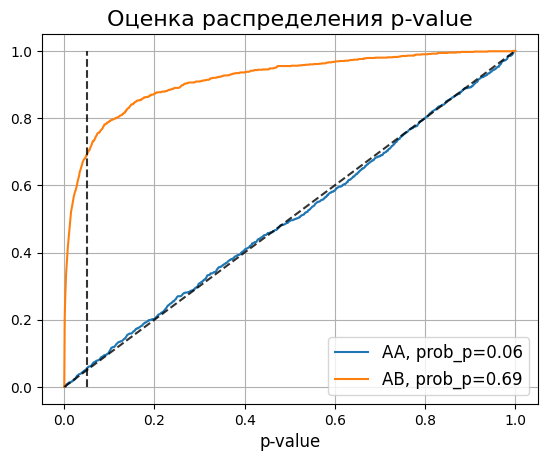

In [8]:
plot_pvalue_distribution_power(dict_pvalues)

### Оценим эксперимент бутстрепом

In [9]:
df_pilot = df[df['date'] >= datetime(2024, 5, 11)].copy()
a, b = [
    df_pilot[df_pilot['group'] == group].groupby('user_id')['value'].apply(list).tolist()
    for group in [0, 1]
]
pvalue, pe = check_bootstrap_ratio(a, b, n=10000)
pvalue, pe

(0.2345261460934953, 13.513984962406028)

#### Недостатки бутстрепа

- скорость работы
- непонятно как применять методы повышения чувствительности

# 4. Линеаризация

Алгоритм применения линеаризации для оценки эксперимента с метрикой-отношения:
$$\mathfrak{R}_V = \frac{\sum_{u\in V} X(u)}{\sum_{u\in V} Y(u)}, \quad V=A, B$$

1. Для каждого пользователя вычисляем линеаризованную метрику по формуле $$L(u) = X(u) -\kappa Y(u), \quad \kappa = \mathfrak{R}_A$$
2. Опционально, к полученной пользовательской метрике можно применить какие-либо способы повышения чувствительности;
3. Вычислияем значение t-статистики критерия Стьюдента и соответствующее значение pvalue;
4. Принимаем решение согласно дизайну эксперимента.


In [10]:
def check_linearization(a, b):
    """Проверка гипотезы с помощью линеаризации.
    
    a: List[List], список списков длин сессий пользователей контрольной группы
    b: List[List], список списков длин сессий пользователей пилотной группы

    return: (pvalue, pe) - pvalue и точечная оценка.
    """
    a_x = np.array([np.sum(row) for row in a])
    a_y = np.array([len(row) for row in a])
    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])
    
    kappa = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - kappa * a_y
    b_lin = b_x - kappa * b_y
    _, pvalue = stats.ttest_ind(a_lin, b_lin)
    delta = np.mean(b_lin) - np.mean(a_lin)
    return pvalue, delta

Проверим корректность работы линеаризации на исторических данных.

  0%|          | 0/3000 [00:00<?, ?it/s]

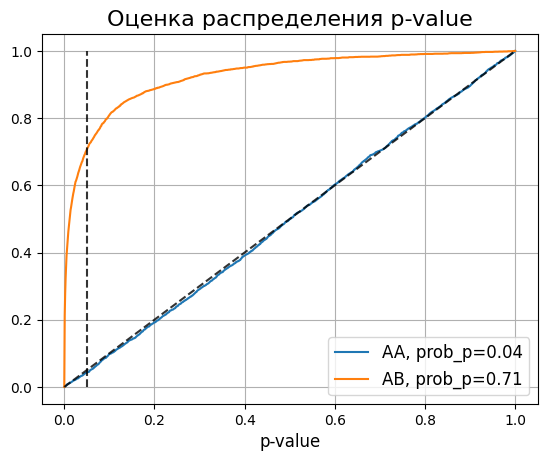

In [11]:
sample_size = 500
effect = 30

lengths = df_prepilot.groupby('user_id')['value'].apply(list).values
# lengths = df_pilot.groupby('user_id')['value'].apply(list).values

len_ = len(lengths)
dict_pvalues = defaultdict(list)
for _ in tqdm(range(3000)):
    a, b = np.random.choice(lengths, (2, sample_size), False)
    pvalue_aa = check_linearization(a, b)[0]
    dict_pvalues['AA'].append(pvalue_aa)
    b_effect = [list(np.array(row) + effect) for row in b]
    pvalue_ab = check_linearization(a, b_effect)[0]
    dict_pvalues['AB'].append(pvalue_ab)

plot_pvalue_distribution_power(dict_pvalues)

### Оценим эксперимент линеаризацией

In [12]:
a, b = [
    df_pilot[df_pilot['group'] == group].groupby('user_id')['value'].apply(list).tolist()
    for group in [0, 1]
]
pvalue, pe = check_linearization(a, b)
pvalue, pe

(0.24704253674219706, 22.033671134357633)

# 5. Линеаризация + CUPED

Алгоритм применения линеаризации с CUPED:

1. Подготовить данные по предэкспериментальному и экспериментальному периодам;
2. Посчитать линеаризованные метрики для каждого пользователя на экспериментальном и предэкспериментальном периодах;
3. К значениям линеаризованных метрик применить CUPED;
4. Получить p-value и принять решение.


![image info](./06-ratio_lin_cuped.png)

### Реализация Линеаризации + CUPED


In [13]:
def calculate_theta(metrics, covariates):
    """Вычисляем Theta.

    metrics - значения исходной метрики
    covariates - значения ковариаты

    return - theta.
    """
    covariance = np.cov(covariates, metrics)[0, 1]
    variance = covariates.var()
    theta = covariance / variance
    return theta


def check_cuped(df_control, df_pilot):
    """Проверяет гипотезу о равенстве средних с использованием CUPED.
    
    Датафреймы df_control и df_pilot содержат столбцы:
        - metric - значение метрики
        - covariate - значение ковариаты

    :param df_control (pd.DataFrame): данные контрольной группы
    :param df_pilot (pd.DataFrame): данные экспериментальной группы

    return - pvalue, точечная оценка
    """
    df_theta = pd.concat([df_control, df_pilot])
    theta = calculate_theta(df_theta['metric'], df_theta['covariate'])
    metric_cuped_control = df_control['metric'] - theta * df_control['covariate']
    metric_cuped_pilot = df_pilot['metric'] - theta * df_pilot['covariate']
    _, pvalue = stats.ttest_ind(metric_cuped_control, metric_cuped_pilot)
    pe = np.mean(metric_cuped_pilot) - np.mean(metric_cuped_control)
    return pvalue, pe

In [14]:
def check_linearization_cuped(a, b):
    """Проверка гипотезы с помощью линеаризации и CUPED.

    Датафреймы a и b содержат столбцы:
        - x - сумма значение метрики во время эксперимента
        - y - кол-во значение метрики во время эксперимента
        - prev_x - сумма значение метрики до эксперимента
        - prev_y - кол-во значение метрики до эксперимента
        - covariate - значение ковариаты

    :param a (pd.DataFrame): данные контрольной группы
    :param b (pd.DataFrame): данные экспериментальной группы

    return: (pvalue, pe) - pvalue и точечная оценка.
    """
    kappa = a['x'].sum() / a['y'].sum()
    for df_ in [a, b]:
        df_['metric'] = df_['x'] - kappa * df_['y']
        df_['covariate'] = df_['prev_x'] - kappa * df_['prev_y']
    pvalue, pe = check_cuped(a, b)
    return pvalue, pe

Проверим корректность работы. Изменилась ли мощность?

Подготовим данные.
1. Сгруппируем данные во время эксперимента по пользователям. Для каждого пользователя, попавшего в эксперимент, вычислим количество сессий и их суммарную длину. Пользователь попал в эксперимент (в одну из групп), если во время эксперимента у него были сессии.
2. Сделаем аналогичную группировку для данных до эксперимента.
3. Смёржим получившиеся датафреймы по 'user_id'. В итоговом датафрейме должны остаться только пользователи попавшие в эксперимент. Если у пользователя не было сессий до эксперимента, то количество сессий и их суммарную длину положите равными нулю.

В итоге должен получится датафрейм с индексами из 'user_id' и столбцами: `x`, `y`, `prev_x`, `prev_y`.


In [15]:
df_pilot_agg = df_pilot.groupby('user_id')['value'].agg(['count', 'mean'])
df_pilot_agg.columns = ['y', 'x']
df_prepilot_agg = df_prepilot.groupby('user_id')['value'].agg(['count', 'mean'])
df_prepilot_agg.columns = ['prev_y', 'prev_x']
df_agg = pd.merge(
    df_pilot_agg, df_prepilot_agg, left_index=True, right_index=True, how='left'
).fillna(0)

Построим распределения pvalue

  0%|          | 0/3000 [00:00<?, ?it/s]

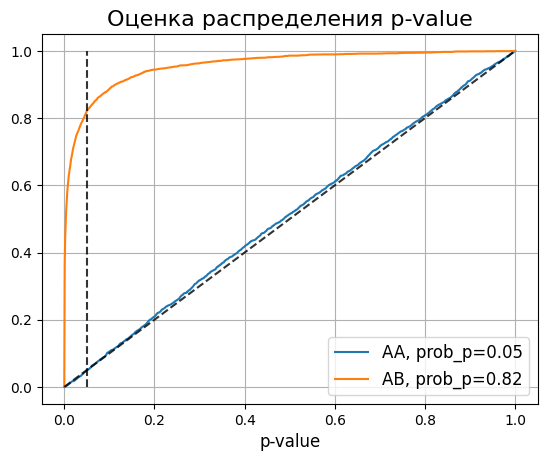

In [18]:
sample_size = 500
effect = 30

indexes = np.arange(len(df_agg))
dict_pvalues = defaultdict(list)
for _ in tqdm(range(3000)):
    a_indexes, b_indexes = np.random.choice(indexes, (2, sample_size), False)
    a = df_agg.iloc[a_indexes].copy()
    b = df_agg.iloc[b_indexes].copy()
    pvalue_aa = check_linearization_cuped(a, b)[0]
    dict_pvalues['AA'].append(pvalue_aa)
    b['x'] += effect * b['y']
    pvalue_ab = check_linearization_cuped(a, b)[0]
    dict_pvalues['AB'].append(pvalue_ab)

plot_pvalue_distribution_power(dict_pvalues)

### Оценим эксперимент линеаризацией + CUPED

In [19]:
user_ids_a, user_ids_b = [
    df_pilot[df_pilot['group'] == group]['user_id'].values for group in [0, 1]
]
a, b = [df_agg.loc[user_ids] for user_ids in [user_ids_a, user_ids_b]]
pvalue, pe = check_linearization_cuped(a, b)
pvalue, pe

(0.00032441387996840724, 38.467843210378675)